<H1>Clustering analysis to separate star/galaxies in a survey</H1>
<H2>Thiago P. Carneiro - 2021</H2>

**GOAL**

Correctly distinguish between stars and galaxies in a catalog using a variety of machine learning techniques.

**INTRODUCTION**

Surveys map astronomical numbers of both stars and galaxies (among others) on their catalogues. Stars, in particular, aren't of interest to many cosmological analysis. However, their visual aspect can be mistaken for an elliptical galaxy. Considering the rapidly growing rate at which new data is being acquired, we need to be able to automatically sift stars from other celestial bodies in such catalogues with confidence.



**WHAT AM I GOING TO DO?**

I'll approach the problem of identifying stars in a catalog using multiple ML techniques (e.g. Random Forest Trees, Logistic Regression, etc.), measuring how well each approach partitions the data. The results will allow us to evaluate which methods are the best ones for this task.


# Cabeçalho

In [72]:
# 2021 Thiago Pacheco Carneiro

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import time

from astropy.io import fits
from astropy.table import Table

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
def open_fits_catalog(fits_file):
    hdu_list=fits.open(fits_file, ignore_missing_end=True)
    #print hdu_list
    hdu = hdu_list[1]    # table extensions can't be the first extension, so there's a dummy image extension at 0
    #print hdu.header
    cat_table = Table(hdu.data)
    cols=hdu.columns
    return cat_table, cols

# Limpeza

In [3]:
arquivo_fits='specz_debom_allsky_SDSSDR16.fits'
tabela, colunas = open_fits_catalog(arquivo_fits)

In [4]:
tabela

specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
float64,float64,float64,str6,float64,float64,str8,str12,str8,str12,str8,str12,str8,str12
2.994896769751716e+17,146.71421,-1.0413043,GALAXY,0.02127545,9.121824e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
2.994896774449336e+17,146.71421,-1.0413043,GALAXY,0.02122228,9.465381e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
2.994899518530785e+17,146.91945,-0.99049175,GALAXY,0.2139246,5.23439e-05,19.89724,0.221153,18.66516,0.04116745,17.66371,0.01830017,17.29358,0.02671436
2.994899523228406e+17,146.74413,-0.65219064,GALAXY,0.2037833,3.89048e-05,20.79233,0.3380686,19.23255,0.03877875,17.79019,0.01971692,17.21832,0.01794012
2.994905016088924e+17,146.85983,-0.80890165,GALAXY,0.1265536,6.185426e-05,20.59526,0.3731141,18.65869,0.0299438,17.43989,0.01589669,16.9439,0.01493528
2.9949050207865446e+17,146.62857,-0.76513683,GALAXY,0.06465632,2.0662e-05,19.72187,0.1515515,17.708,0.02945771,16.83504,0.02319035,16.39123,0.01871121
2.9949077648679936e+17,146.76339,-0.81043316,GALAXY,0.4486449,0.0001679451,25.79026,5.215773,21.34879,0.4266613,19.29993,0.09123418,18.621,0.07033348
2.994910513647063e+17,146.9639,-0.54500256,GALAXY,0.05598787,1.141557e-05,null,null,null,null,null,null,null,null
2.9949105183446835e+17,146.63167,-0.98827781,GALAXY,0.05265425,8.614109e-06,19.50893,0.101994,18.38805,0.02164089,17.84603,0.01789545,17.53182,0.02207784


In [5]:
colunas.names

['specObjID',
 'ra',
 'dec',
 'class',
 'z',
 'zErr',
 'petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [6]:
colunas_numéricas = colunas.names[1:3]+colunas.names[4:]
colunas_numéricas

['ra',
 'dec',
 'z',
 'zErr',
 'petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [7]:
tabela[colunas_numéricas]

ra,dec,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
float64,float64,float64,float64,str8,str12,str8,str12,str8,str12,str8,str12
146.71421,-1.0413043,0.02127545,9.121824e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
146.71421,-1.0413043,0.02122228,9.465381e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
146.91945,-0.99049175,0.2139246,5.23439e-05,19.89724,0.221153,18.66516,0.04116745,17.66371,0.01830017,17.29358,0.02671436
146.74413,-0.65219064,0.2037833,3.89048e-05,20.79233,0.3380686,19.23255,0.03877875,17.79019,0.01971692,17.21832,0.01794012
146.85983,-0.80890165,0.1265536,6.185426e-05,20.59526,0.3731141,18.65869,0.0299438,17.43989,0.01589669,16.9439,0.01493528
146.62857,-0.76513683,0.06465632,2.0662e-05,19.72187,0.1515515,17.708,0.02945771,16.83504,0.02319035,16.39123,0.01871121
146.76339,-0.81043316,0.4486449,0.0001679451,25.79026,5.215773,21.34879,0.4266613,19.29993,0.09123418,18.621,0.07033348
146.9639,-0.54500256,0.05598787,1.141557e-05,null,null,null,null,null,null,null,null
146.63167,-0.98827781,0.05265425,8.614109e-06,19.50893,0.101994,18.38805,0.02164089,17.84603,0.01789545,17.53182,0.02207784


In [8]:
df=tabela.to_pandas()
df

,specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,2.994897e+17,146.714210,-1.041304,GALAXY,0.021275,0.000009,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
1,2.994897e+17,146.714210,-1.041304,GALAXY,0.021222,0.000009,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
2,2.994900e+17,146.919450,-0.990492,GALAXY,0.213925,0.000052,19.89724,0.221153,18.66516,0.04116745,17.66371,0.01830017,17.29358,0.02671436
3,2.994900e+17,146.744130,-0.652191,GALAXY,0.203783,0.000039,20.79233,0.3380686,19.23255,0.03877875,17.79019,0.01971692,17.21832,0.01794012
4,2.994905e+17,146.859830,-0.808902,GALAXY,0.126554,0.000062,20.59526,0.3731141,18.65869,0.0299438,17.43989,0.01589669,16.9439,0.01493528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338062,4.459433e+17,15.039689,-0.179618,STAR,-0.000560,0.000011,18.27383,0.01478433,17.1798,0.003236198,16.96035,0.003409309,16.91121,0.004151301
3338063,4.459435e+17,15.323412,-0.294214,GALAXY,0.189903,0.000015,19.88128,0.07333352,18.93501,0.01849458,18.43681,0.01837495,18.13481,0.02082617
3338064,4.459441e+17,15.172908,-0.444550,GALAXY,0.043709,0.000011,18.2541,0.04377979,16.51601,0.01310113,15.73698,0.01387848,15.38086,0.01292664
3338065,4.459446e+17,15.731016,1.140221,GALAXY,0.143501,0.000032,20.88922,0.3276213,18.68918,0.01786709,17.5765,0.0113072,17.111,0.01180846


A função do pandas
> to_numeric

com a opção
> errors='coerce'

transforma tudo que não é conversível para número em NaN.

In [9]:
for coluna in colunas_numéricas:
    df[coluna]=pd.to_numeric(df[coluna],errors='coerce')
df

,specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,2.994897e+17,146.714210,-1.041304,GALAXY,0.021275,0.000009,17.12867,0.021027,15.61450,0.009458,14.84587,0.008145,14.44303,0.008185
1,2.994897e+17,146.714210,-1.041304,GALAXY,0.021222,0.000009,17.12867,0.021027,15.61450,0.009458,14.84587,0.008145,14.44303,0.008185
2,2.994900e+17,146.919450,-0.990492,GALAXY,0.213925,0.000052,19.89724,0.221153,18.66516,0.041167,17.66371,0.018300,17.29358,0.026714
3,2.994900e+17,146.744130,-0.652191,GALAXY,0.203783,0.000039,20.79233,0.338069,19.23255,0.038779,17.79019,0.019717,17.21832,0.017940
4,2.994905e+17,146.859830,-0.808902,GALAXY,0.126554,0.000062,20.59526,0.373114,18.65869,0.029944,17.43989,0.015897,16.94390,0.014935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338062,4.459433e+17,15.039689,-0.179618,STAR,-0.000560,0.000011,18.27383,0.014784,17.17980,0.003236,16.96035,0.003409,16.91121,0.004151
3338063,4.459435e+17,15.323412,-0.294214,GALAXY,0.189903,0.000015,19.88128,0.073334,18.93501,0.018495,18.43681,0.018375,18.13481,0.020826
3338064,4.459441e+17,15.172908,-0.444550,GALAXY,0.043709,0.000011,18.25410,0.043780,16.51601,0.013101,15.73698,0.013878,15.38086,0.012927
3338065,4.459446e+17,15.731016,1.140221,GALAXY,0.143501,0.000032,20.88922,0.327621,18.68918,0.017867,17.57650,0.011307,17.11100,0.011808


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338067 entries, 0 to 3338066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   specObjID      float64
 1   ra             float64
 2   dec            float64
 3   class          object 
 4   z              float64
 5   zErr           float64
 6   petroMag_u     float64
 7   petroMagErr_u  float64
 8   petroMag_g     float64
 9   petroMagErr_g  float64
 10  petroMag_r     float64
 11  petroMagErr_r  float64
 12  petroMag_i     float64
 13  petroMagErr_i  float64
dtypes: float64(13), object(1)
memory usage: 356.5+ MB


In [11]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318621 entries, 0 to 3338066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   specObjID      float64
 1   ra             float64
 2   dec            float64
 3   class          object 
 4   z              float64
 5   zErr           float64
 6   petroMag_u     float64
 7   petroMagErr_u  float64
 8   petroMag_g     float64
 9   petroMagErr_g  float64
 10  petroMag_r     float64
 11  petroMagErr_r  float64
 12  petroMag_i     float64
 13  petroMagErr_i  float64
dtypes: float64(13), object(1)
memory usage: 379.8+ MB


In [12]:
(df==-9999.0).sum()

specObjID          0
ra                 0
dec                0
class              0
z                  0
zErr               0
petroMag_u       163
petroMagErr_u    163
petroMag_g       153
petroMagErr_g    153
petroMag_r       120
petroMagErr_r    120
petroMag_i       136
petroMagErr_i    136
dtype: int64

In [13]:
for coluna in colunas_numéricas:
    df=df[df[coluna]!=-9999.0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318450 entries, 0 to 3338066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   specObjID      float64
 1   ra             float64
 2   dec            float64
 3   class          object 
 4   z              float64
 5   zErr           float64
 6   petroMag_u     float64
 7   petroMagErr_u  float64
 8   petroMag_g     float64
 9   petroMagErr_g  float64
 10  petroMag_r     float64
 11  petroMagErr_r  float64
 12  petroMag_i     float64
 13  petroMagErr_i  float64
dtypes: float64(13), object(1)
memory usage: 379.8+ MB


# Análise

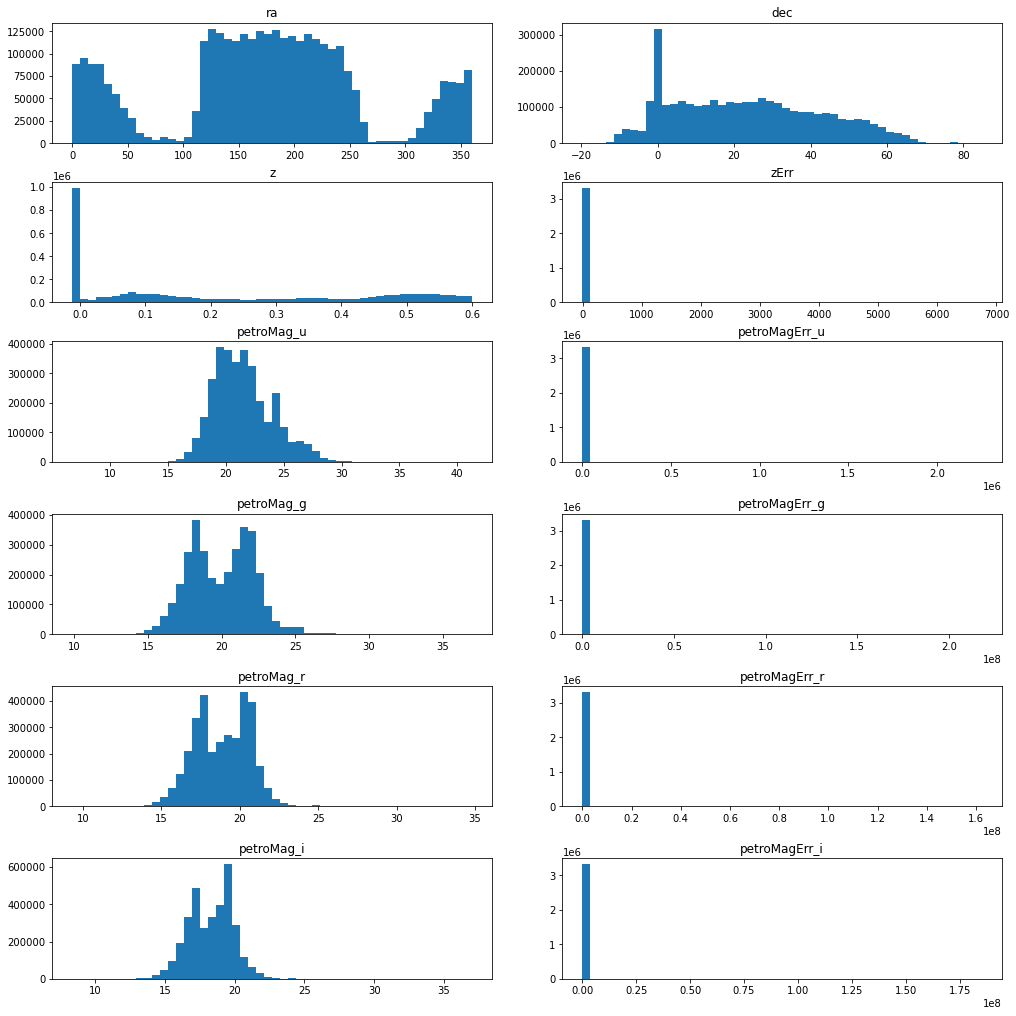

In [14]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
metade_das_colunas = (len(colunas_numéricas)+1)//2
gs = fig.add_gridspec(metade_das_colunas,2, left=0.05, right=0.5, wspace=0.05)

for i, coluna in enumerate(colunas_numéricas):
    ax = fig.add_subplot(gs[i//2, i%2])
    ax.hist(df[coluna],bins=50)
    ax.set_title(coluna)

Nota-se a concentração de z em 1.

In [15]:
classes=np.unique(df['class'])
classes

array(['GALAXY', 'QSO   ', 'STAR  '], dtype=object)

In [16]:
df['class']=df['class'].str.strip()
classes=np.unique(df['class'])
classes

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [17]:
x = list(df.columns[4:])
x

['z',
 'zErr',
 'petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [18]:
df['classe_n']=(2 * (df['class']=='STAR'))-1
df['classe_n']

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
3338062    1
3338063   -1
3338064   -1
3338065   -1
3338066   -1
Name: classe_n, Length: 3318450, dtype: int64

<AxesSubplot:>

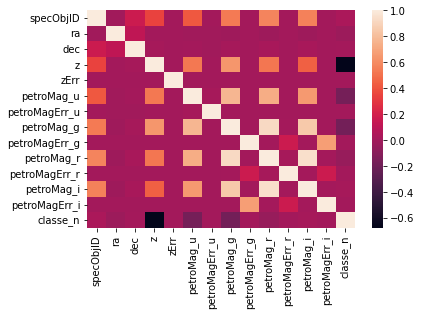

In [19]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Notamos que _classe_n_ tem boa correlação com _z_.

# Decision Tree

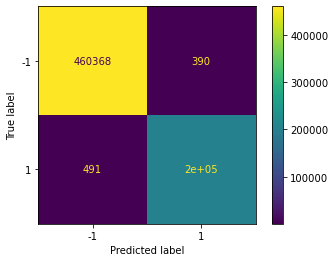

In [114]:
classificador_dt = tree.DecisionTreeClassifier().fit(treino[x],treino['classe_n'])
predições_dt = classificador_dt.predict(teste[x])
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_dt)

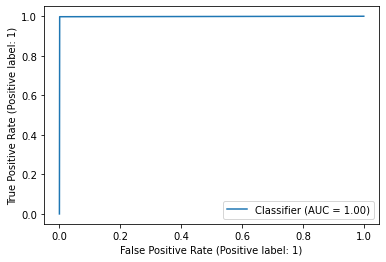

In [115]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_dt)

[Text(284.4533277975788, 215.90873239436618, 'X[0] <= 0.003\ngini = 0.424\nsamples = 2322915\nvalue = [1615720, 707195]'),
 Text(237.180804197155, 212.84619718309858, 'X[0] <= 0.002\ngini = 0.005\nsamples = 708649\nvalue = [1952, 706697]'),
 Text(159.2175673681896, 209.78366197183098, 'X[0] <= -0.004\ngini = 0.004\nsamples = 707583\nvalue = [1530, 706053]'),
 Text(76.80746847525607, 206.72112676056338, 'X[0] <= -0.004\ngini = 0.161\nsamples = 34\nvalue = [31, 3]'),
 Text(76.6185965625876, 203.65859154929578, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]'),
 Text(76.99634038792453, 203.65859154929578, 'X[2] <= 22.992\ngini = 0.5\nsamples = 6\nvalue = [3, 3]'),
 Text(76.80746847525607, 200.59605633802818, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(77.185212300593, 200.59605633802818, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(241.62766626112315, 206.72112676056338, 'X[0] <= 0.001\ngini = 0.004\nsamples = 707549\nvalue = [1499, 706050]'),
 Text(181.9328790427313, 203.6585915492

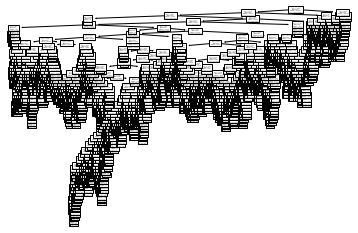

In [186]:
tree.plot_tree(classificador_dt)

# Random Forest

In [20]:
tamanho_treino = int(.7 * len(df))
tamanho_teste = int(.2 * len(df))
treino, teste, validação = np.split(df.sample(frac=1),[tamanho_treino,tamanho_treino+tamanho_teste])
print(f'{len(treino) = }, {len(teste) = }, {len(validação) = }')

len(treino) = 2322915, len(teste) = 663690, len(validação) = 331845


In [105]:
classificador_rf = [0] * 9
for i in range(9):
    print(2**(i+1), 'estimadores')
    início = time.perf_counter()
    classificador_rf[i] = RandomForestClassifier(n_estimators=2**(i+1),n_jobs=-1).fit(treino[x],treino['class'])
    fim = time.perf_counter()
    print(fim-início, 'segundos')

2 estimadores
24.490386500008754 segundos
4 estimadores
22.41851124999812 segundos
8 estimadores
35.82570800000394 segundos
16 estimadores
61.642468874997576 segundos
32 estimadores
112.19983237500128 segundos
64 estimadores
211.7543297499942 segundos
128 estimadores
488.57791866600746 segundos
256 estimadores
943.7217933330103 segundos
512 estimadores
2060.017840040993 segundos


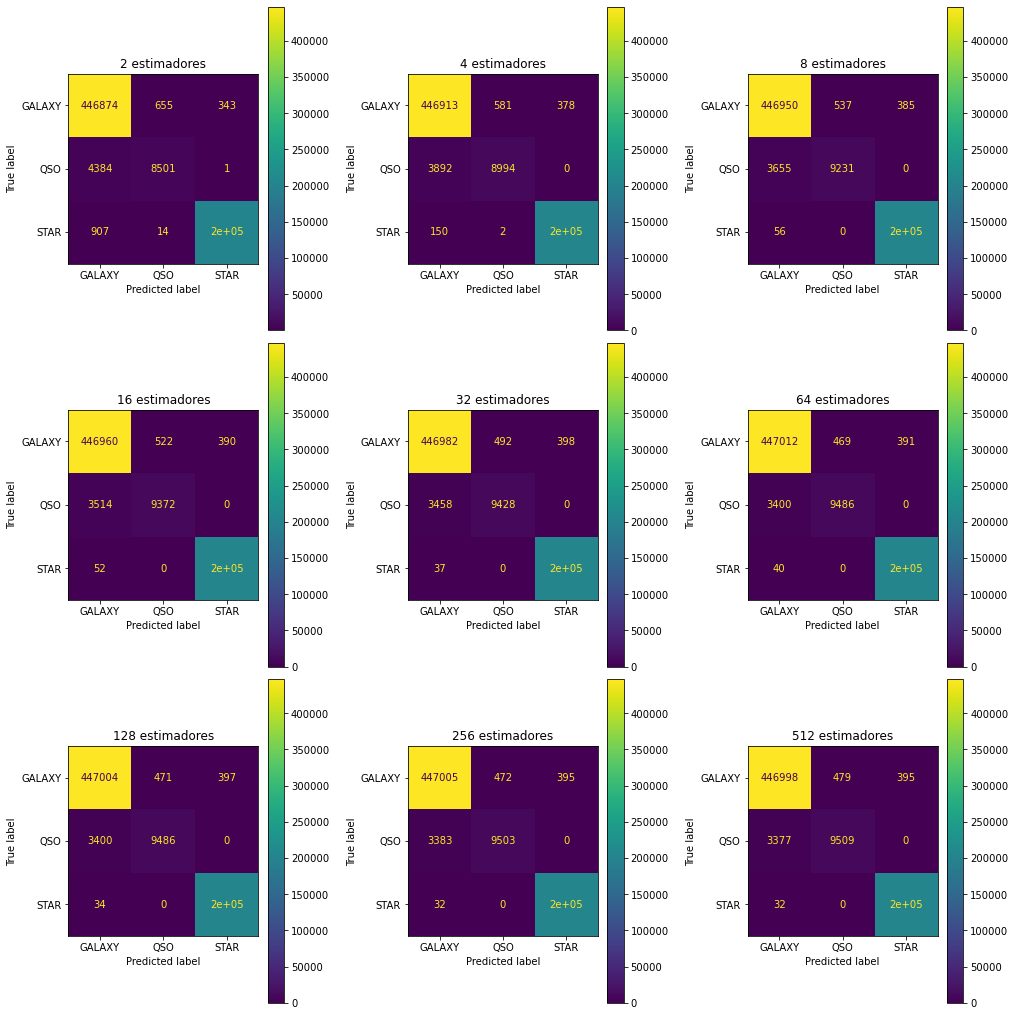

In [106]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    ConfusionMatrixDisplay.from_estimator(classificador_rf[i],teste[x],teste['class'],ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

Nota-se que mesmo o pior classificador erra menos de 1% das classificações.

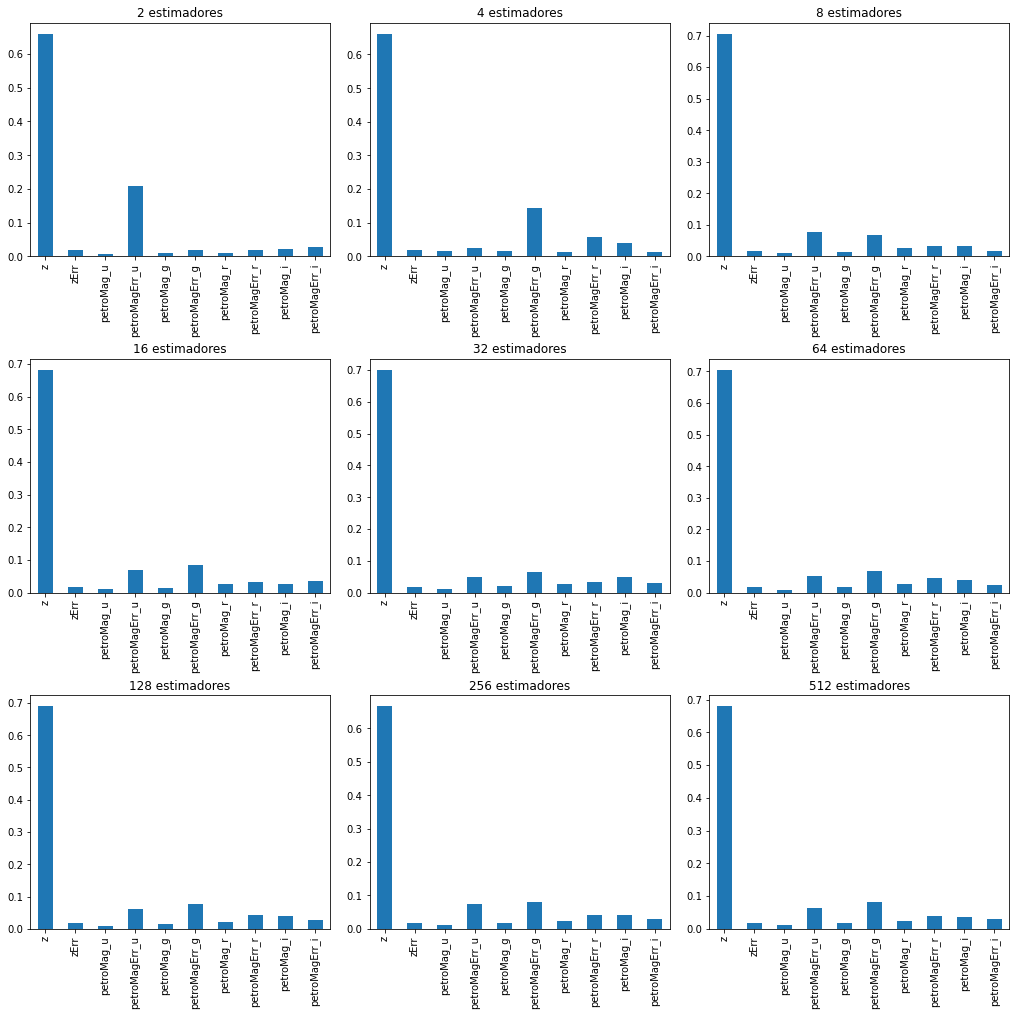

In [107]:
feature_names = list((treino[x].columns))

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    importances = classificador_rf[i].feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    ax = fig.add_subplot(gs[i//3, i%3])
    forest_importances.plot.bar(ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

Conforme poderíamos esperar pela matriz de correlação, _z_ é o fator mais importante em qualquer classificador.

Para obter a curva ROC pracisamos de um classificador binário, então usamos _classe_n_, que tem apenas as classes estrela (+1) e não-estrela (-1):

In [109]:
classificador_rf_b = [0] * 9
for i in range(9):
    print(2**(i+1), 'estimadores')
    início = time.perf_counter()
    classificador_rf_b[i] = RandomForestClassifier(n_estimators=2**(i+1),n_jobs=-1).fit(treino[x],treino['classe_n'])
    fim = time.perf_counter()
    print(fim-início, 'segundos')

2 estimadores
8.131982334001805 segundos
4 estimadores
8.206295542011503 segundos
8 estimadores
13.631309499993222 segundos
16 estimadores
27.433106249998673 segundos
32 estimadores
48.04471637500683 segundos
64 estimadores
105.2076335830061 segundos
128 estimadores
223.584071958001 segundos
256 estimadores
471.61945487500634 segundos
512 estimadores
890.5797174170002 segundos


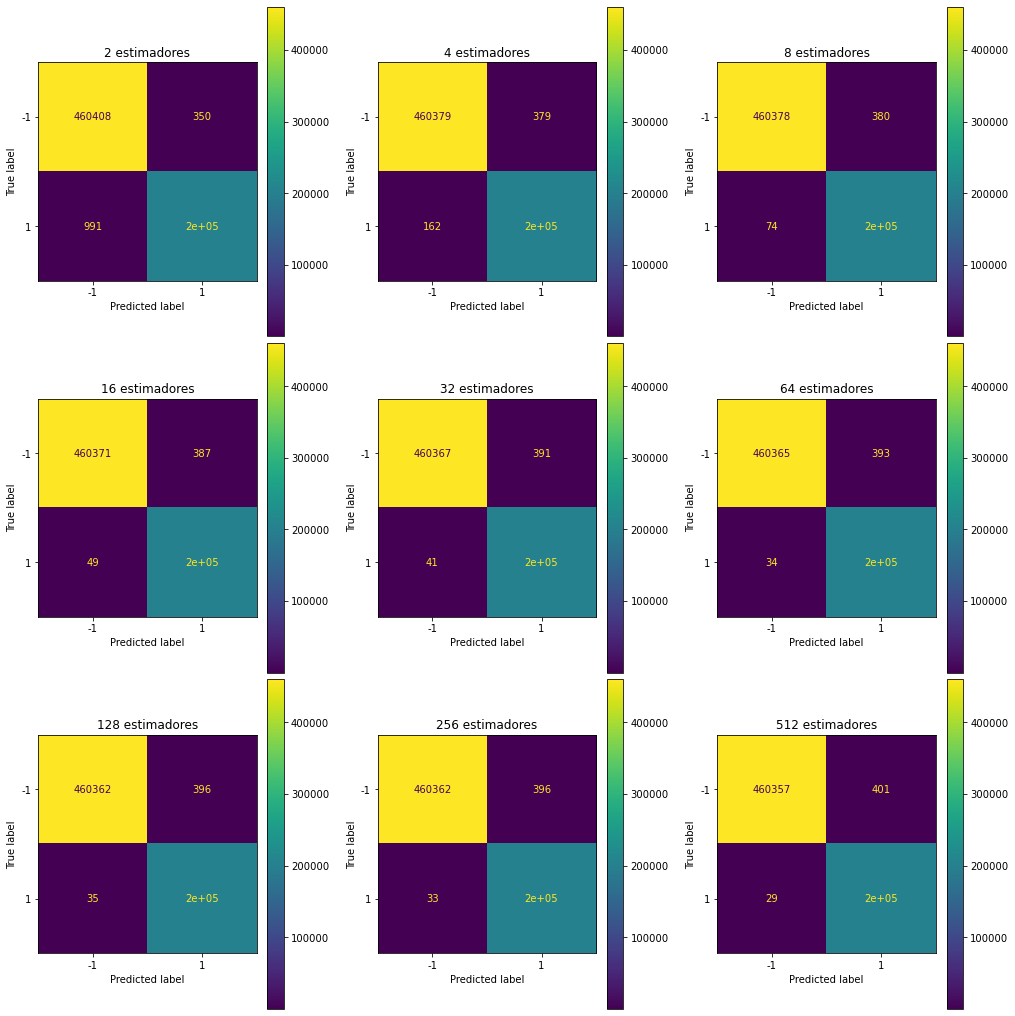

In [110]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    ConfusionMatrixDisplay.from_estimator(classificador_rf_b[i],teste[x],teste['classe_n'],ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

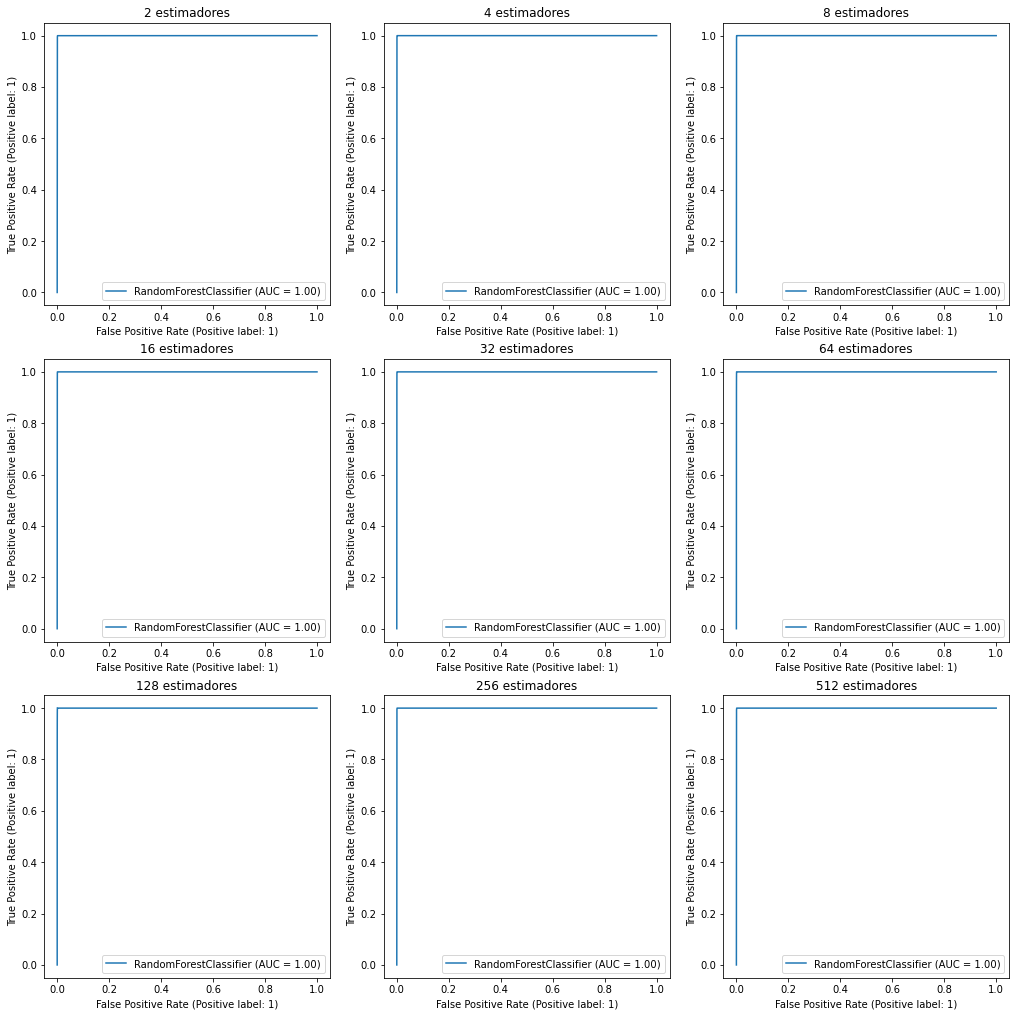

In [111]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    RocCurveDisplay.from_estimator(classificador_rf_b[i],teste[x],teste['classe_n'],ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

Mesmo para o classificador mais simples, a AUC ficou em 1!

## Classificando sem _z_

Como o classificador se sairia sem _z_? Toda a capacidade de classificação depende desse elemento? Vamos testar sem _z_ e sem _zErr_

In [112]:
u = x[2:]
u

['petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [117]:
classificador_rf_u = [0] * 9
for i in range(9):
    print(2**(i+1), 'estimadores')
    início = time.perf_counter()
    classificador_rf_u[i] = RandomForestClassifier(n_estimators=2**(i+1),n_jobs=-1).fit(treino[u],treino['classe_n'])
    fim = time.perf_counter()
    print(fim-início, 'segundos')

2 estimadores
10.520432207995327 segundos
4 estimadores
12.984253250004258 segundos
8 estimadores
20.047976292000385 segundos
16 estimadores
43.9500172919943 segundos
32 estimadores
99.6137152500014 segundos
64 estimadores
205.8104147080012 segundos
128 estimadores
421.61088424999616 segundos
256 estimadores
874.2705996250006 segundos
512 estimadores
1670.1618160409998 segundos


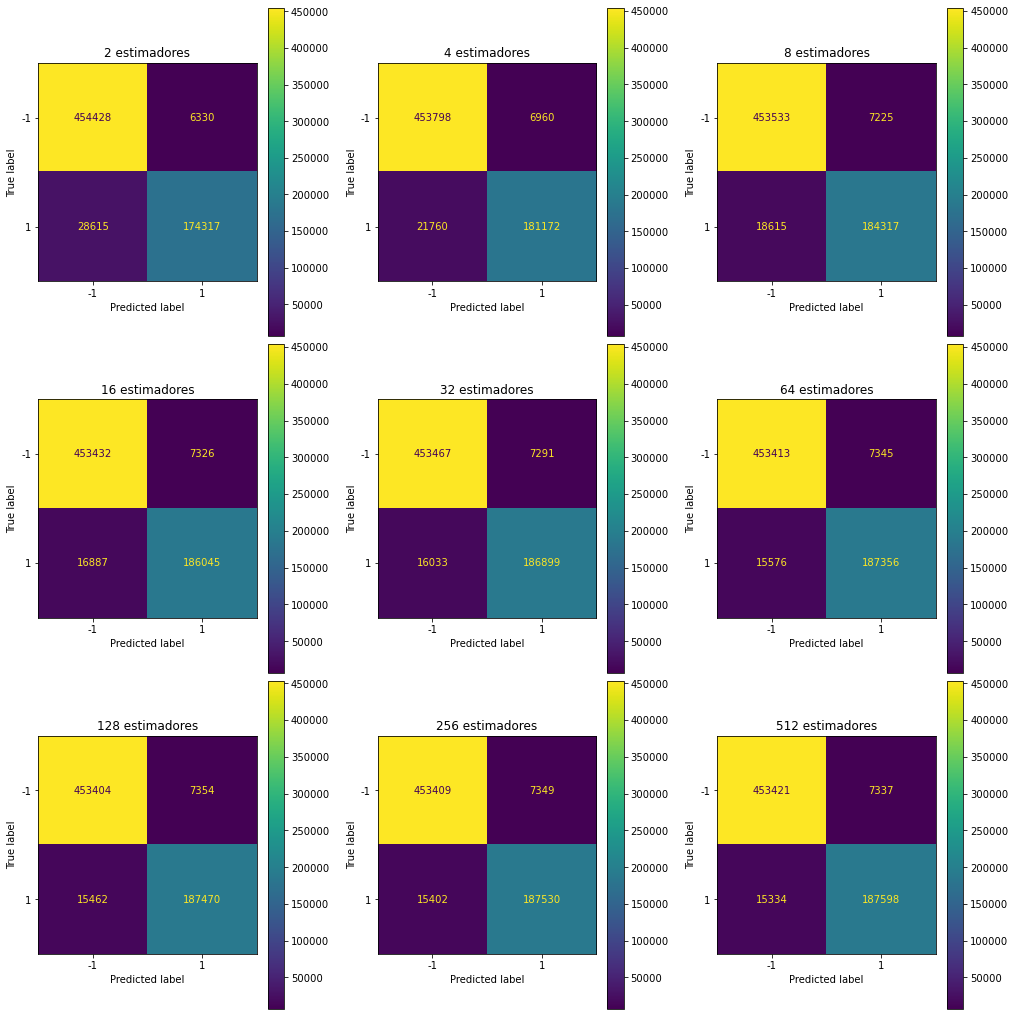

In [118]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    ConfusionMatrixDisplay.from_estimator(classificador_rf_u[i],teste[u],teste['classe_n'],ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

Podemos ver que embora tenha um desempenho muito pior do que com _z_ à sua disposição, pudemos obter classificadores com erros na casa de 5%.

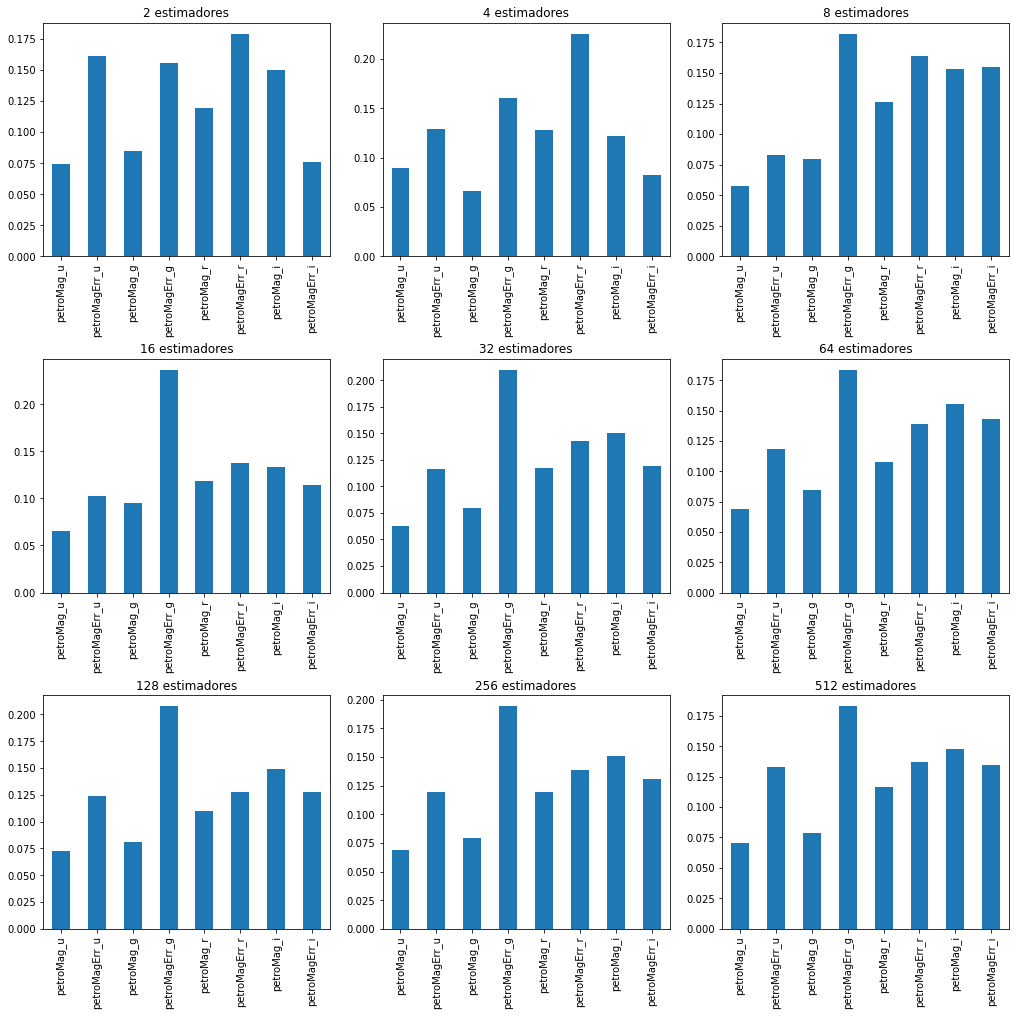

In [119]:
feature_names = list((treino[u].columns))

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    importances = classificador_rf_u[i].feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    ax = fig.add_subplot(gs[i//3, i%3])
    forest_importances.plot.bar(ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

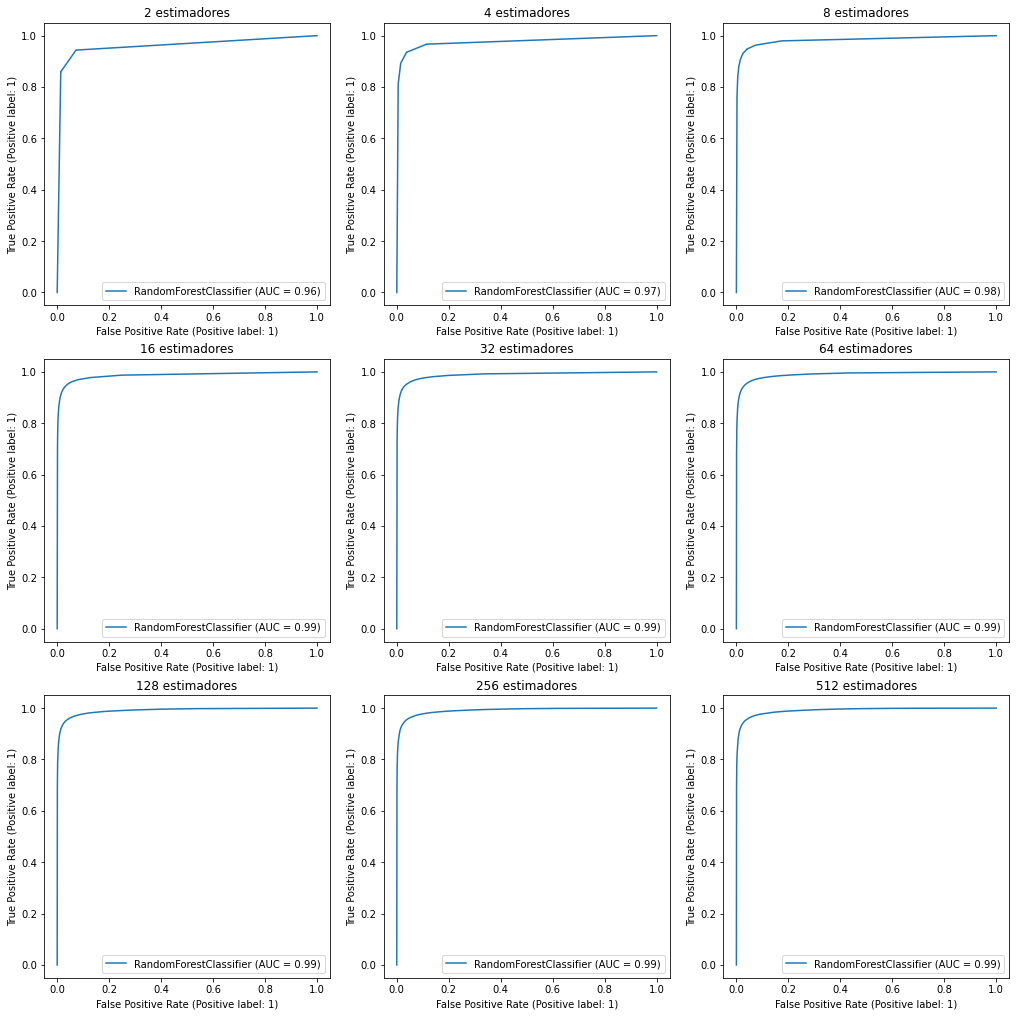

In [120]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    RocCurveDisplay.from_estimator(classificador_rf_u[i],teste[u],teste['classe_n'],ax=ax)
    ax.set_title(f'{2**(i+1)} estimadores')

As AUCs mostram a boa capacidade de classificação das Random Forests, mesmo sem _z_.

# Logistic Regression

In [32]:
classificador_lr = LogisticRegression().fit(treino[x],treino['classe_n'])

In [33]:
predições_lr = classificador_lr.predict(teste[x])
classificador_lr.score(teste[x],teste['classe_n'])

0.694235260437855

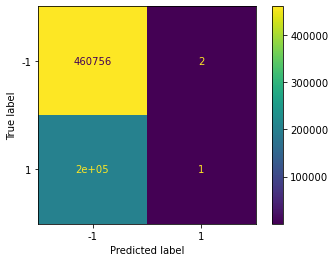

In [34]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lr)

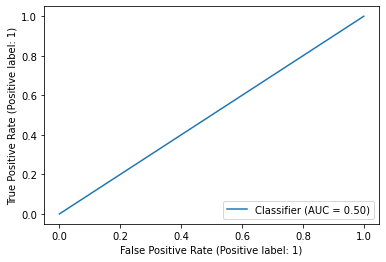

In [35]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lr)

In [36]:
sc = StandardScaler()
x_treino_escalonado = sc.fit_transform(treino[x])
x_teste_escalonado = sc.transform(teste[x])
x_validação_escalonado = sc.transform(validação[x])

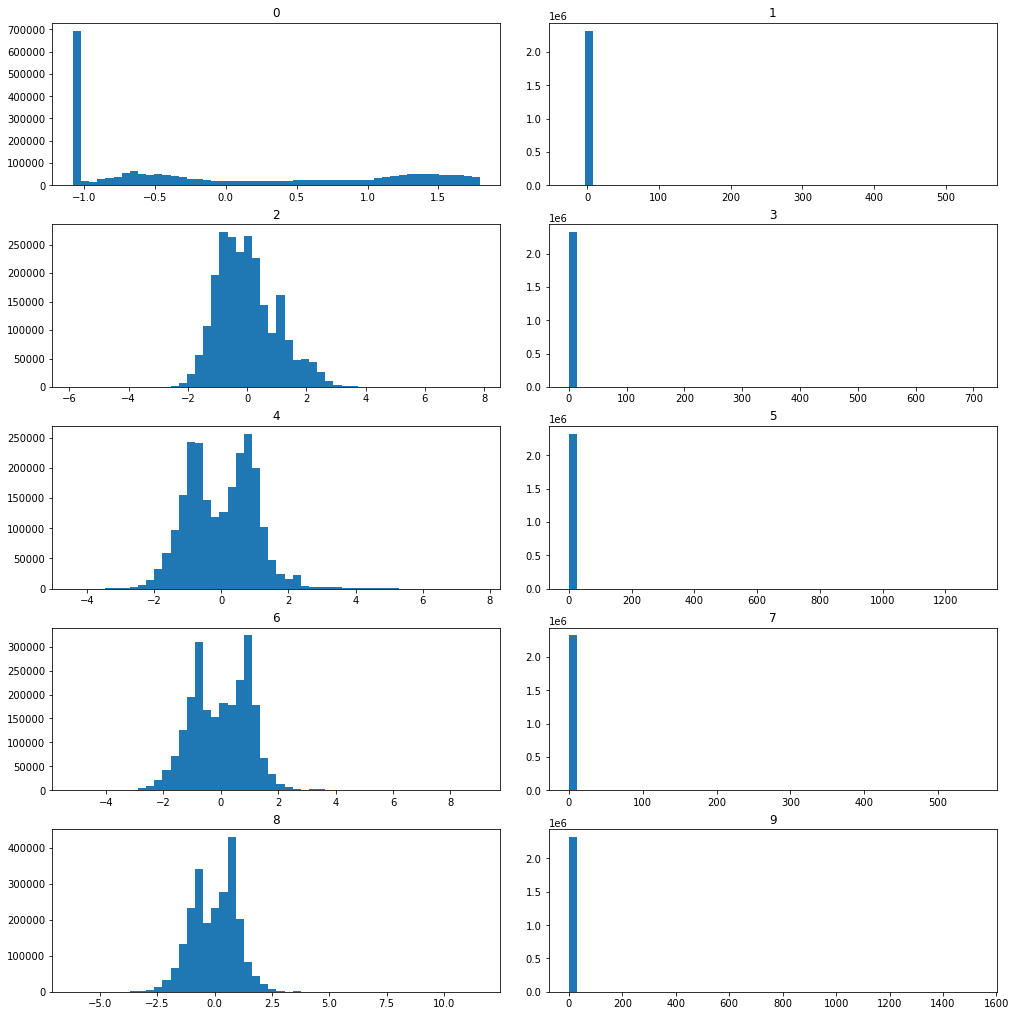

In [94]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
metade_das_colunas = ((x_treino_escalonado.shape[1])+1)//2
gs = fig.add_gridspec(metade_das_colunas,2, left=0.05, right=0.5, wspace=0.05)

for i, coluna in enumerate(range(x_treino_escalonado.shape[1])):
    ax = fig.add_subplot(gs[i//2, i%2])
    ax.hist(x_treino_escalonado[:,coluna],bins=50)
    ax.set_title(coluna)

In [37]:
classificador_lr_escalonado = LogisticRegression().fit(x_treino_escalonado,treino['classe_n'])

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
rs = RobustScaler()
x_treino_robusto = rs.fit_transform(treino[x])
x_teste_robusto = rs.transform(teste[x])
x_validação_robusto = rs.transform(validação[x])

In [39]:
classificador_lr_robusto = LogisticRegression()
classificador_lr_robusto.fit(x_treino_robusto,treino['classe_n'])

LogisticRegression()

In [40]:
predições_lr_robusto = classificador_lr_robusto.predict(x_teste_robusto)
classificador_lr_robusto.score(x_teste_robusto,teste['classe_n'])

0.5957525350690834

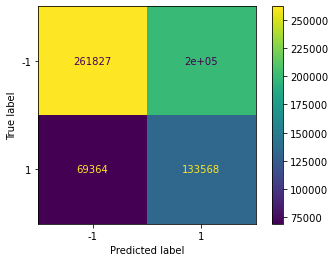

In [41]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lr_robusto)

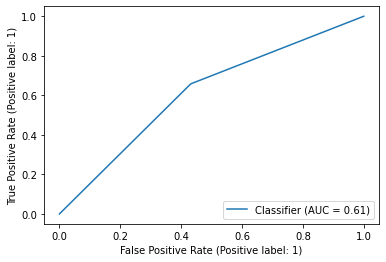

In [42]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lr_robusto)

In [43]:
classificador_lr_z = LogisticRegression().fit(np.array(treino['z']).reshape(-1,1),treino['classe_n'])
predições_lr_z = classificador_lr_z.predict(np.array(teste['z']).reshape(-1,1))
classificador_lr_z.score(np.array(teste['z']).reshape(-1,1),teste['classe_n'])

0.9955144721180069

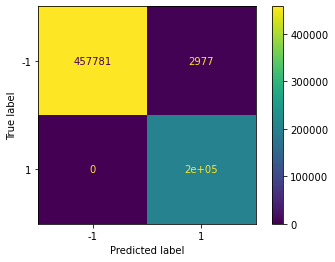

In [44]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lr_z)

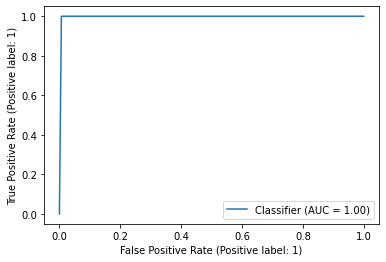

In [45]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lr_z)

# LightGBM

In [47]:
d_treino = lgb.Dataset(x_treino_escalonado,label=treino['classe_n'])

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

regressor_lgb = lgb.train(params, d_treino,100)

[LightGBM] [Info] Number of positive: 707195, number of negative: 1615720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2322915, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304443 -> initscore=-0.826230
[LightGBM] [Info] Start training from score -0.826230


<Figure size 1008x1008 with 0 Axes>

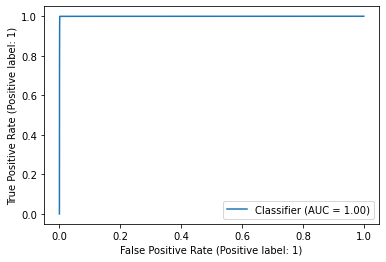

In [48]:
predições_lgb = regressor_lgb.predict(x_teste_escalonado)

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb)

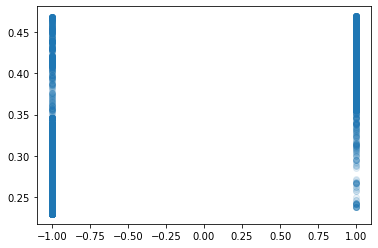

In [49]:
plt.scatter(teste['classe_n'],predições_lgb,alpha=0.1)

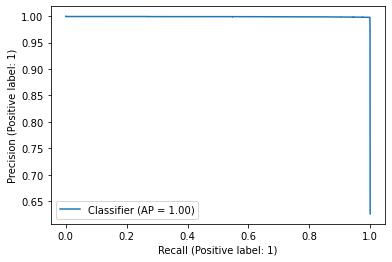

In [50]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(teste['classe_n'],predições_lgb)

(array([3.37104e+05, 3.23960e+04, 1.63120e+04, 8.38300e+03, 1.12300e+04,
        1.68540e+04, 8.35900e+03, 8.00700e+03, 9.45200e+03, 3.76100e+03,
        4.46300e+03, 3.87400e+03, 9.80000e+01, 1.18000e+02, 7.20000e+01,
        1.59000e+02, 1.91100e+03, 1.67100e+03, 1.43300e+03, 2.53500e+03,
        1.53800e+03, 1.92200e+03, 7.56400e+03, 9.64300e+03, 8.21100e+03,
        1.36250e+04, 2.23040e+04, 1.87870e+04, 2.74800e+04, 8.44240e+04]),
 array([0.22931702, 0.23731695, 0.24531688, 0.25331682, 0.26131675,
        0.26931668, 0.27731662, 0.28531655, 0.29331648, 0.30131642,
        0.30931635, 0.31731628, 0.32531622, 0.33331615, 0.34131608,
        0.34931602, 0.35731595, 0.36531588, 0.37331582, 0.38131575,
        0.38931568, 0.39731561, 0.40531555, 0.41331548, 0.42131541,
        0.42931535, 0.43731528, 0.44531521, 0.45331515, 0.46131508,
        0.46931501]),
 <BarContainer object of 30 artists>)

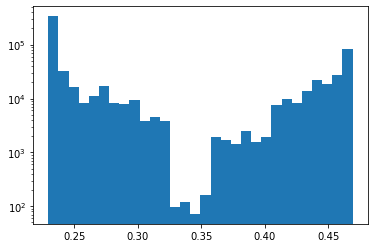

In [51]:
plt.hist(predições_lgb,bins=30,log=True)

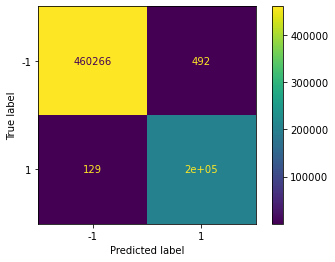

In [52]:
predições_lgb_b = (predições_lgb>0.34)*2 - 1
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgb_b)

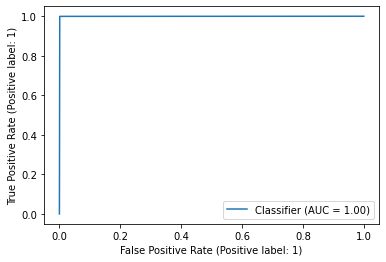

In [53]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb_b)

In [54]:
classificador_lgbc = lgb.LGBMClassifier()
classificador_lgbc.fit(x_treino_escalonado, treino['classe_n'])

LGBMClassifier()

In [55]:
predições_lgbc = classificador_lgbc.predict(x_teste_escalonado)

from sklearn.metrics import accuracy_score
accuracy_score(teste['classe_n'],predições_lgbc)

0.9990884298392322

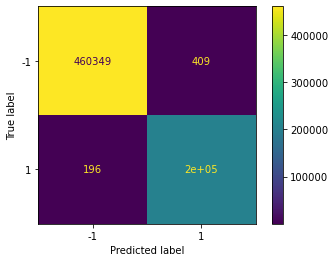

In [56]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgbc)

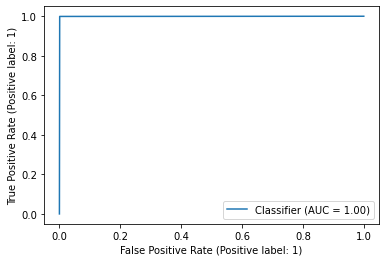

In [57]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgbc)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(teste['classe_n'],predições_lgbc))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00    460758
           1       1.00      1.00      1.00    202932

    accuracy                           1.00    663690
   macro avg       1.00      1.00      1.00    663690
weighted avg       1.00      1.00      1.00    663690



## LightGBM sem _z_

In [59]:
sc_u = StandardScaler()
u_treino_escalonado = sc_u.fit_transform(treino[u])
u_teste_escalonado = sc_u.transform(teste[u])
u_validação_escalonado = sc_u.transform(validação[u])

In [60]:
d_treino_u = lgb.Dataset(u_treino_escalonado,label=treino['classe_n'])

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

regressor_lgb_u = lgb.train(params, d_treino_u,100)

[LightGBM] [Info] Number of positive: 707195, number of negative: 1615720
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 2322915, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304443 -> initscore=-0.826230
[LightGBM] [Info] Start training from score -0.826230


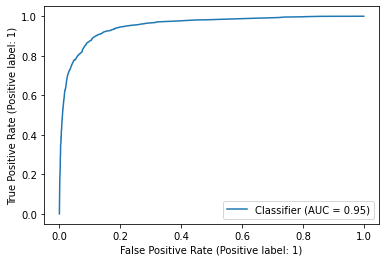

In [61]:
predições_lgb_u = regressor_lgb_u.predict(u_teste_escalonado)

RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb_u)

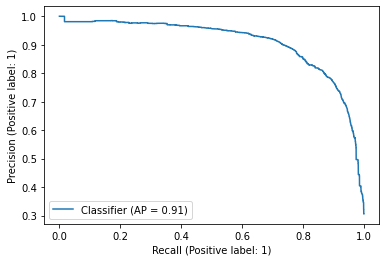

In [62]:
display = PrecisionRecallDisplay.from_predictions(teste['classe_n'],predições_lgb_u)

(array([126750., 204163.,  39014.,  17622.,  12709.,   6171.,   5812.,
          5446.,   4957.,   4423.,   5082.,   7556.,   6013.,   5855.,
         23971.,   9813.,   4296.,   5398.,   6106.,   6352.,   5487.,
          6795.,   7896.,   9625.,  10456.,  10731.,  12086.,  23608.,
         28284.,  41213.]),
 array([0.23785353, 0.2450744 , 0.25229527, 0.25951613, 0.266737  ,
        0.27395787, 0.28117873, 0.2883996 , 0.29562047, 0.30284133,
        0.3100622 , 0.31728307, 0.32450394, 0.3317248 , 0.33894567,
        0.34616654, 0.3533874 , 0.36060827, 0.36782914, 0.37505   ,
        0.38227087, 0.38949174, 0.39671261, 0.40393347, 0.41115434,
        0.41837521, 0.42559607, 0.43281694, 0.44003781, 0.44725867,
        0.45447954]),
 <BarContainer object of 30 artists>)

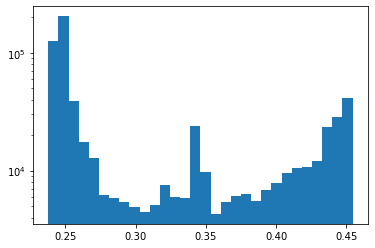

In [63]:
plt.hist(predições_lgb_u,bins=30,log=True)

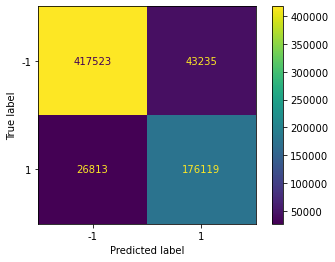

In [64]:
predições_lgb_b_u = (predições_lgb_u>0.33)*2 - 1
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgb_b_u)

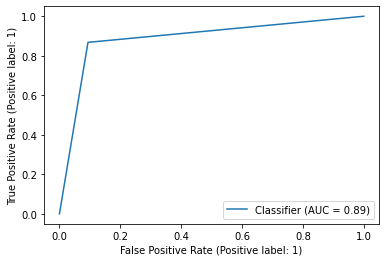

In [65]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb_b_u)

In [66]:
classificador_lgbc_u = lgb.LGBMClassifier()
classificador_lgbc_u.fit(u_treino_escalonado, treino['classe_n'])

LGBMClassifier()

In [67]:
predições_lgbc_u = classificador_lgbc_u.predict(u_teste_escalonado)

accuracy_score(teste['classe_n'],predições_lgbc_u)

0.9535249890762253

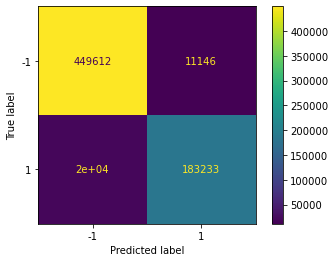

In [68]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgbc_u)

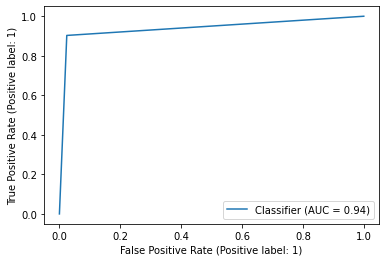

In [69]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgbc_u)

In [70]:
print(classification_report(teste['classe_n'],predições_lgbc_u))

              precision    recall  f1-score   support

          -1       0.96      0.98      0.97    460758
           1       0.94      0.90      0.92    202932

    accuracy                           0.95    663690
   macro avg       0.95      0.94      0.94    663690
weighted avg       0.95      0.95      0.95    663690



# TabNet

In [74]:
classificador_tabnet = TabNetClassifier(verbose=1,seed=42)
classificador_tabnet.fit(X_train=treino[x].to_numpy(), y_train=treino['classe_n'].to_numpy(),patience=5,max_epochs=100, eval_metric=['auc'],
    eval_set=[(treino[x].to_numpy(),treino['classe_n'].to_numpy()),
              (validação[x].to_numpy(),validação['classe_n'].to_numpy())
             ],
    eval_name=('treino','validação'))
predições_tabnet = classificador_tabnet.predict_proba(teste[x].to_numpy())[:,1]

Device used : cpu
epoch 0  | loss: 0.01299 | treino_auc: 0.99959 | validação_auc: 0.99964 |  0:02:36s
epoch 1  | loss: 0.00554 | treino_auc: 0.99963 | validação_auc: 0.99969 |  0:05:10s
epoch 2  | loss: 0.00541 | treino_auc: 0.00061 | validação_auc: 0.00052 |  0:07:47s
epoch 3  | loss: 0.00547 | treino_auc: 0.99953 | validação_auc: 0.99956 |  0:10:22s
epoch 4  | loss: 0.00532 | treino_auc: 0.99958 | validação_auc: 0.99963 |  0:13:00s
epoch 5  | loss: 0.00528 | treino_auc: 0.99954 | validação_auc: 0.9996  |  0:15:38s
epoch 6  | loss: 0.00521 | treino_auc: 0.99954 | validação_auc: 0.99955 |  0:18:16s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_validação_auc = 0.99969
Best weights from best epoch are automatically used!


(array([4.60089e+05, 1.13000e+02, 9.20000e+01, 4.90000e+01, 4.90000e+01,
        4.10000e+01, 4.20000e+01, 3.10000e+01, 1.60000e+01, 2.40000e+01,
        1.10000e+01, 1.60000e+01, 2.50000e+01, 2.10000e+01, 1.30000e+01,
        1.00000e+01, 1.60000e+01, 1.20000e+01, 1.80000e+01, 1.60000e+01,
        1.10000e+01, 2.70000e+01, 2.30000e+01, 2.70000e+01, 3.00000e+01,
        3.50000e+01, 3.90000e+01, 3.50000e+01, 4.90000e+01, 6.00000e+01,
        4.30000e+01, 6.00000e+01, 6.50000e+01, 6.60000e+01, 7.20000e+01,
        7.50000e+01, 7.60000e+01, 8.20000e+01, 9.70000e+01, 1.27000e+02,
        1.28000e+02, 1.33000e+02, 1.58000e+02, 1.91000e+02, 2.10000e+02,
        1.79000e+02, 2.55000e+02, 2.58000e+02, 2.82000e+02, 3.10000e+02,
        3.43000e+02, 3.68000e+02, 4.10000e+02, 4.08000e+02, 5.22000e+02,
        5.72000e+02, 6.64000e+02, 7.93000e+02, 8.83000e+02, 9.97000e+02,
        1.17500e+03, 1.35800e+03, 1.63500e+03, 1.87500e+03, 2.24500e+03,
        2.65800e+03, 2.95200e+03, 3.18000e+03, 3.68

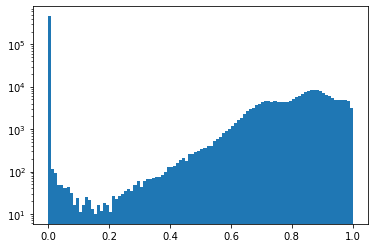

In [75]:
plt.hist(predições_tabnet,bins=100,log=True)

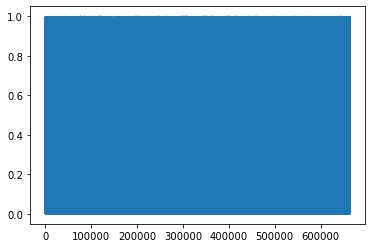

In [76]:
plt.plot(predições_tabnet)

In [77]:
np.percentile(predições_tabnet,50)

4.591461902236915e-06

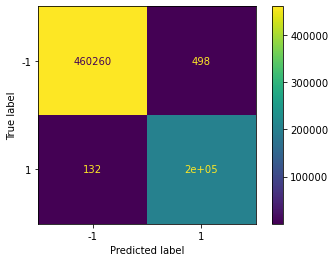

In [93]:
predições_tabnet_b = (predições_tabnet>0.05)*2 -1
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_tabnet_b) 

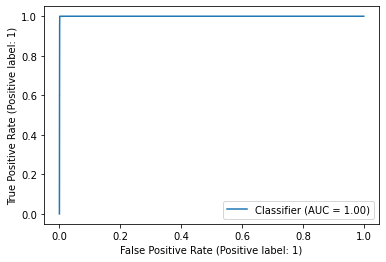

In [79]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_tabnet)

# Modelo Composto

In [173]:
treino[x]

,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
2260466,-0.000329,0.000045,23.32624,1.995275,21.06315,0.099106,20.40718,0.085032,20.17788,0.105508
2913534,-0.000638,0.000041,23.85702,1.588255,21.18715,0.092039,20.59880,0.153344,20.15569,0.277273
2772667,0.489020,0.000168,24.68585,4.132532,22.54916,0.719171,20.83316,0.307961,19.67245,0.182957
3291717,0.539293,0.000027,21.80506,0.668449,22.60147,0.333312,22.06374,0.393137,22.56577,0.892221
19910,0.113163,0.000036,21.15688,0.234247,19.04094,0.017549,17.96114,0.012979,17.43555,0.012204
...,...,...,...,...,...,...,...,...,...,...
1576812,-0.000057,0.000008,20.45289,0.061347,18.09910,0.005397,17.03498,0.003321,16.66118,0.003458
3018777,0.000219,0.000214,22.08120,0.265384,21.47562,0.070429,21.38461,0.105651,21.52370,0.166413
1510209,-0.000191,0.000004,18.20932,0.014091,16.24005,0.002149,15.37480,0.001621,15.04408,0.001970
3063705,0.383163,0.000079,22.07938,0.609633,21.27714,0.211554,19.85836,0.096516,19.33057,0.073271


In [176]:
tmp = treino[x].copy()
tmp['LR'] = classificador_lr_z.predict(np.array(treino['z']).reshape(-1,1))
classificador_composto = RandomForestClassifier(n_estimators=32,n_jobs=-1).fit(tmp,treino['classe_n'])

In [178]:
tmp = teste[x].copy()
tmp['LR'] = classificador_lr_z.predict(np.array(teste['z']).reshape(-1,1))
predições_composto = classificador_composto.predict(tmp)

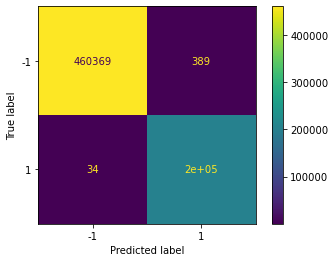

In [179]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_composto)

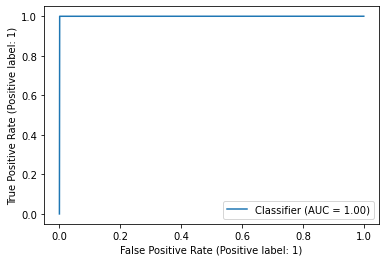

In [180]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_composto)

# Performance e Conclusão

In [160]:
tempos = {}
FP = {}
FN = {}

In [161]:
início = time.perf_counter()
tmp = classificador_dt.predict(teste[x])
fim = time.perf_counter()
tempos['DecisionTree']=fim-início
FP['DecisionTree']=((teste['classe_n']!=tmp) & (tmp == 1)).sum()
FN['DecisionTree']=((teste['classe_n']!=tmp) & (tmp == -1)).sum()


In [162]:

for idx, clf in enumerate(classificador_rf_b):
    início = time.perf_counter()
    tmp = clf.predict(teste[x])
    fim = time.perf_counter()
    rf_name = f'Random Forest {2**(idx+1)}'
    tempos[rf_name]=fim-início
    FP[rf_name]=((teste['classe_n']!=tmp) & (tmp == 1)).sum()
    FN[rf_name]=((teste['classe_n']!=tmp) & (tmp == -1)).sum()

In [163]:
tmp = np.array(teste['z']).reshape(-1,1)
início = time.perf_counter()
tmp = classificador_lr_z.predict(tmp)
fim = time.perf_counter()
tempos['Logistic Regression']=fim-início
FP['Logistic Regression']=((teste['classe_n']!=tmp) & (tmp == 1)).sum()
FN['Logistic Regression']=((teste['classe_n']!=tmp) & (tmp == -1)).sum()

In [164]:
início = time.perf_counter()
tmp = classificador_lgbc.predict(x_teste_escalonado)
fim = time.perf_counter()
tempos['LightGBM']=fim-início
FP['LightGBM']=((teste['classe_n']!=tmp) & (tmp == 1)).sum()
FN['LightGBM']=((teste['classe_n']!=tmp) & (tmp == -1)).sum()

In [165]:
tmp = teste[x].to_numpy()
início = time.perf_counter()
tmp = classificador_tabnet.predict_proba(tmp)
fim = time.perf_counter()
tempos['TabNet']=fim-início
tmp = tmp[:,0]<0.5
FP['TabNet']=((teste['classe_n']!=tmp) & (tmp == 1)).sum()
FN['TabNet']=((teste['classe_n']!=tmp) & (tmp == -1)).sum()

In [181]:
tmp = teste[x].copy()
início = time.perf_counter()
tmp['LR'] = classificador_lr_z.predict(np.array(teste['z']).reshape(-1,1))
tmp = classificador_composto.predict(tmp)
fim = time.perf_counter()
tempos['Composto']=fim-início
FP['Composto']=((teste['classe_n']!=tmp) & (tmp == 1)).sum()
FN['Composto']=((teste['classe_n']!=tmp) & (tmp == -1)).sum()

<BarContainer object of 14 artists>

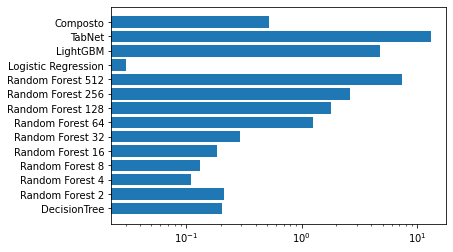

In [182]:
plt.barh(list(tempos.keys()),tempos.values(),log=True)

In [183]:
FP

{'DecisionTree': 390,
 'Random Forest 2': 350,
 'Random Forest 4': 379,
 'Random Forest 8': 380,
 'Random Forest 16': 387,
 'Random Forest 32': 391,
 'Random Forest 64': 393,
 'Random Forest 128': 396,
 'Random Forest 256': 396,
 'Random Forest 512': 401,
 'Logistic Regression': 2977,
 'LightGBM': 409,
 'TabNet': 355,
 'Composto': 389}

In [184]:
FN

{'DecisionTree': 491,
 'Random Forest 2': 991,
 'Random Forest 4': 162,
 'Random Forest 8': 74,
 'Random Forest 16': 49,
 'Random Forest 32': 41,
 'Random Forest 64': 34,
 'Random Forest 128': 35,
 'Random Forest 256': 33,
 'Random Forest 512': 29,
 'Logistic Regression': 0,
 'LightGBM': 196,
 'TabNet': 0,
 'Composto': 34}

In [185]:
pd.DataFrame({'FP':FP,'FN':FN,'Tempo':tempos}).to_csv('resultados.csv')